# Deep Learning Course - Spring 2025 - Sharif University of Technology
## Homework 4 - DDPM (60 points + 34 extra points)

*Instructor:  Dr. Soleymani*

---

*Full Name:* Mobina Poulaei

*SID:* 403206962

---

This homework helps you implement a Denoising Diffusion Probabilistic Model (DDPM) and Classifier-free diffusion guidance.  
As the main part, you can use the [DDPM paper](https://arxiv.org/pdf/2006.11239.pdf) and [classifier-free guidance](https://arxiv.org/abs/2207.12598) as references.

In this homework you need to complete the notebook and run all the cells.
We have specified the parts to be completed with `TODO` tags inside the code blocks.

**NOTES**:
* It is important that you read all the code and text blocks carefully, even if you think you are excited to jump into completing the missing codes.
* This notebook is tested with *Google Colab* and *Kaggle* free runtimes and you can used them for testing your code.
* Ensure all cells are executable and perform their intended functions
* You can ask your questions on [Quera Class](https://quera.org/course/20754)
* Write clear, commented code when necessary.

# Introduction

Denoising Diffusion Probabilistic Models (DDPMs) are deep generative models that have recently gained significant attention due to their remarkable performance. Cutting-edge models such as OpenAI’s DALL-E 2 and Google’s Imagen generators are built upon DDPMs.

The core concept is straightforward: given an image dataset, we progressively add small amounts of noise in multiple steps. With each step, the image becomes increasingly unclear until it turns into pure noise—this is known as the "forward process." Then, we train a machine learning model to reverse these steps, a process referred to as the "backward process." If the backward process is successfully learned, the model can generate images from random noise.

In the forward process, each step involves adding noise to an image (denoted as $x_t$) by sampling from a multivariate Gaussian distribution. The mean of this distribution is a scaled-down version of the previous image ($x_{t-1}$), while the covariance matrix remains diagonal and fixed. Essentially, each pixel in the image is independently perturbed by adding a normally distributed value.

![image](https://learnopencv.com/wp-content/uploads/2023/01/diffusion-models-forwardbackward_process_ddpm.png)

For the backward process, the model is expected to follow a Gaussian distribution, meaning it must predict the mean and standard deviation of the distribution given the noisy image and time step. In the original DDPM paper, the covariance matrix is fixed, so the primary objective is to predict the mean of the Gaussian distribution based on the noisy image and the current time step.

![image](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models-overall_forward_diffusion_process-1.png)

## 1. Unconditional DDPM (60 points)

We will explore the details of both the forward (diffusion) and backward (denoising) processes in the relevant sections.

In this assignment, our goal is to implement a DDPM from scratch to generate random MNIST images from noise. Additionally, we aim to condition our DDPM on the MNIST label, enabling it to generate images corresponding to specific class.

In [ ]:
!pip install torchmetrics
!pip install torchvision
!pip install torchmetrics[image] torch-fidelity --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

## 1.1. Packages

In [ ]:
import os
import math
from abc import abstractmethod

from PIL import Image
import requests
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

##########################################################
# Add other packages below here in the case you need them for the extra parts
from scipy.linalg import sqrtm
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.models import resnet18
from torchvision.transforms import ToPILImage
from torch.utils.data import Dataset, DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
##########################################################

In [ ]:
def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 1.2. Dataset
As it was mentioned, for this assignment we use the MNIST dataset, and we aim to generate the similar images of this dataset by our DDPM. For loading the dataset, you can use torchvision. You should apply this transformations for loading images:

* convert them into a tensor
* and normalize values to a `mean` and `standard deviation` of 0.5.

In [ ]:
##########################################################
# TODO (1 points):
# Define the required transforms based on the explanations.
# Instructions: Fill in the missing transforms inside the
# Compose function.
##########################################################
transform = transforms.Compose([
    # Your code here...
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
#################### END TODO ############################

Now, define an instance of MNIST dataset with the specified transformations and load it to a `dataloader`.

In [ ]:
##########################################################
# TODO (1 points):
# Creating an instance of the MNIST Dataset with
# specified transformations
# then create a dataloader for loading dataset in batches
##########################################################
batch_size = 64
dataset = datasets.MNIST(
          root='./data',
          train=True,
          download=True,
          transform=transform
          )
# Create a Dataloader instance for loading data in batches
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)
#################### END TODO ############################

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.52MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 64.0kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 240kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.24MB/s]


## 1.3. U-Net Architercture (32 points)

The U-Net architecture, a convolutional neural network framework, has become a highly effective solution for semantic segmentation tasks. Its distinctive U-shaped design enables it to efficiently capture both global and local features, allowing it to excel in various segmentation challenges.

U-Net is composed of two main components: a contracting path and an expansive path. The contracting path follows a standard convolutional network structure, involving repeated applications of two 3×3 convolutions (without padding), each followed by a rectified linear unit (ReLU) activation and a 2×2 max pooling operation with a stride of 2 for downsampling. With each downsampling step, the number of feature channels doubles.

The expansive path, on the other hand, consists of upsampling the feature map, followed by a 2×2 convolution ("up-convolution") that reduces the number of feature channels by half. This is then concatenated with the corresponding cropped feature map from the contracting path, followed by two 3×3 convolutions, each accompanied by a ReLU activation.

![unet architecture](https://media.geeksforgeeks.org/wp-content/uploads/20220614121231/Group14.jpg)

The figure above represents the original U-Net architecture introduced in 2015. However, for this assignment, we will work with a modified version that incorporates additional sub-modules. In the subsequent sections, we will define and implement the necessary components to build our final network.

### 1.3.1 time step embedding class
We define the `TimestepEmbedSequential` to support the time embedding as the extra input for the layers of model.

In [ ]:
class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, t_emb):
        for layer in self:
            if(isinstance(layer, TimestepBlock)):
                x = layer(x, t_emb)
            else:
                x = layer(x)
        return x

### 1.3.2 Residual Block


As a fundamental sub-module, each ResNet block consists of two consecutive convolutional layers, with Group Normalization and SiLU activation applied **before** each convolution. This block serves as a building block for other sub-modules, such as Downsampling and Upsampling layers.

Additionally, a linear projection layer transforms the time embedding vector into a vector with the same number of channels as the output. This projected time embedding is then added to the input after the first convolutional layer. By removing the residual connection, this block can also function as a standard convolutional network.

It's important to note that if the number of input and output channels for the feature maps differ, directly adding the input to the output in a residual connection can cause inconsistencies. To address this, a 1×1 convolution can be applied to align the input channels with the output dimensions.

Optionally, a dropout layer can be included before the second convolution layer. By default, the dropout probability is set to zero, but it can be activated as needed in the final architecture.

In [ ]:
# Residual block
class Residual_block(TimestepBlock):
    """
    Residual block for U-Net architecture.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        time_channels (int): Size of the time embedding.
        dropout (float, optional): Dropout probability. Default is 0.
        num_groups (int): Number of groups to split the input into for normalization. Default is 32.
    """
    ##########################################################
    # TODO (6 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self, in_channels, out_channels, time_channels, dropout, num_groups=32):
        super().__init__()
        # Your code here...

        self.norm1 = nn.GroupNorm(num_groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.time_proj = nn.Linear(time_channels, out_channels)

        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        if in_channels != out_channels:
            self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.skip_connection = nn.Identity()

    def forward(self, x, t):
        """
        Forward pass of the ResnetBlock.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        # Your code here...

        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        time_emb = self.time_proj(t)
        time_emb = time_emb.view(time_emb.shape[0], time_emb.shape[1], 1, 1)
        h = h + time_emb

        h = self.norm2(h)
        h = F.silu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        x = self.skip_connection(x)
        return h + x
    #################### END TODO ############################

### 1.3.3 Attention Block
This sub-module consisting of :
 * a Group Normalization
 * Multi-head Attention (Implement from scratch)
 * a feed-forward layer
 * residual conntection

In [ ]:
class AttentionBlock(nn.Module):
    """
    Initializes the AttentionBlock module.

    Args:
        channels (int): Number of input channels.
        num_heads (int): Number of attention heads to use.
        num_groups (int): Number of groups to split the input into for normalization.
    """
    ##########################################################
    # TODO (6 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self, channels, num_groups = 32, num_heads=1):
        super().__init__()
        # Your code here...

        self.channels = channels
        self.num_heads = num_heads
        self.num_groups = num_groups
        self.norm = nn.GroupNorm(num_groups, channels)

        # Linear projections for query, key, value
        self.to_qkv = nn.Conv2d(channels, channels * 3, kernel_size=1, bias=False)
        self.to_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        """
          Forward pass of the AttentionBlock module.

          Args:
              x (torch.Tensor): Input tensor of shape (batch_size, seq_len, channels).

          Returns:
              torch.Tensor: Output tensor
        """
        # Your code here...
        batch_size, channels, height, width = x.shape
        h = self.norm(x)
        qkv = self.to_qkv(h) # (batch_size, channels * 3, height, width)
        qkv = qkv.view(batch_size, 3, self.num_heads, channels // self.num_heads, height * width)
        q, k, v = qkv.chunk(3, dim=1)  # Each: (batch_size, 1, num_heads, head_dim, height * width)

        q = q.squeeze(1)  # (batch_size, num_heads, head_dim, height * width)
        k = k.squeeze(1)  # (batch_size, num_heads, head_dim, height * width)
        v = v.squeeze(1)  # (batch_size, num_heads, head_dim, height * width)

        # Transpose for attention computation
        q = q.transpose(-2, -1)  # (batch_size, num_heads, height * width, head_dim)
        k = k.transpose(-2, -1)  # (batch_size, num_heads, height * width, head_dim)
        v = v.transpose(-2, -1)  # (batch_size, num_heads, height * width, head_dim)

        # Compute attention scores
        scale = (channels // self.num_heads) ** -0.5
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) * scale  # (batch_size, num_heads, height * width, height * width)
        attention_weights = F.softmax(attention_scores, dim=-1)
        out = torch.matmul(attention_weights, v)  # (batch_size, num_heads, height * width, head_dim)

        # Reshape back to original spatial dimensions
        out = out.transpose(-2, -1)  # (batch_size, num_heads, head_dim, height * width)
        out = out.contiguous().view(batch_size, channels, height, width)
        out = self.to_out(out)

        return out + x
    #################### END TODO ############################

### 1.3.4 Down-sampling Block

This block should be used in the contractive path of the model. The downsampling module halves the width and height of the input and can be implemented using either a convolution layer with `stride=2` or an average pooling layer with `kernel_size=2`, which dependes on the boolean argument `use_conv`.

In [ ]:
class Downsample(nn.Module):
    """
    Downsampling block for U-Net architecture.

    Args:
        channels (int): Number of input channels.
        use_conv (bool): Flag indicating whether to use convolution or average pooling.
    """
    ##########################################################
    # TODO (4 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self, channels, use_conv):
        super().__init__()
        # Your code here...

        if use_conv:
          self.down = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
        else:
          self.down = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
      """
        Forward pass of the Downsample block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
      """
      # Your code here...
      return self.down(x)
    #################### END TODO ############################

### 1.3.5 Up-sampling Block

This module should be used in the expansive path of the U-Net model. The main purpose of this module is to doubles the width and height of image tensor. For implementation, ypu can use interpolation followed by an optional convolutional layer (determined by `use_conv` argument)

In [ ]:
class Upsample(nn.Module):
    """
    Upsampling block for U-Net architecture.

    Args:
        channels (int): Number of input channels.
        use_conv (bool): Flag indicating whether to add convolutional layer.
    """
    ##########################################################
    # TODO (4 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self, channels, use_conv):
        super().__init__()
        # Your code here...

        if use_conv:
          self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        else:
          self.conv = nn.Identity()

    def forward(self, x):
        """
        Forward pass of the Upsample block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        # Your code here...

        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.conv(x)
        return x
    #################### END TODO ############################

### 1.3.6 Time Embeddding
In previous sections, we discussed how U-Net predicts noise at each time step. To incorporate the time step into the network, we encode it into an embedding vector and pass it to various layers. Various position encoding methods exist, but we use Sinusoidal position embeddings proposed in the ["Attention is All You Need."](https://arxiv.org/pdf/1706.03762.pdf) paper for this purpose.

In [ ]:
def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    Args:
      timesteps: A 1-D Tensor of N indices, one per batch element.
      dim: the dimension of the output.
      max_period: controls the minimum frequency of the embeddings.
    """
    ##########################################################
    # TODO (4 points):
    # Complete the function with the described
    # instructions.
    ##########################################################
    # Your code here...

    half = dim // 2
    freqs = torch.exp(
          -torch.log(torch.tensor(max_period, dtype=torch.float32))
          * torch.arange(start=0, end=half, dtype=torch.float32) / half
          ).to(device=timesteps.device)

    # timesteps: (N,) -> (N, 1)
    # freqs: (half,) -> (1, half)
    # args: (N, half)
    args = timesteps[:, None] * freqs[None, :]

    # Create sinusoidal embeddings
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    # Handle odd dimensions by padding with zeros if necessary
    if dim % 2 == 1:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)

    return embedding
    #################### END TODO ############################

### 1.3.7 Final architecture
In this part, you should implement the final U-Net model by using the implemented sub-modules in previous parts. You are free to use any architecture for generating the MNIST images. However, for the simplicity, the below architecture for the model is suggested:

* You should Implement the **contarctive path**, **Middle block**, and **expansive path**. For each part:

1. At each level for contractive path, the block architecture includes:
  * Residual Block
  * Attention Block (optional)
  * DownSample Block (except the last level in this path)

2. Middle Block includes:
  * Residual Block
  * Attention Block
  * Residual Block

3. At each level for expansive path, the block architecture includes:
  * Residual Block
  * Attention Block (optional)
  * UpSample Block (except the first level in this path)

Hint:
* The numbers in attention_resolution list are the resolution numbers for blocks consisting the attention block. At first this number equals to 1. If we add `DownSample` block to a block, this number doubles, and If we add `UpSample` block to a block, this number halves. Use this numbering system for determining the blocks with attention in your implementation.

* It is recommended to define a Linear projection layer for time embedding that projects position-encoded time steps to a larger 1-D vector (e.g., $4 \times$ model_channels).
* In the forward pass, all hidden states in the contractive path are added to a tuple and used in the expansive path.

In [ ]:
class UnetModel(nn.Module):
    """
    U-Net model for image generation.

    Args:
        in_channels (int): Number of input channels.
        model_channels (int): Number of channels in the model.
        out_channels (int): Number of output channels.
        num_res_blocks (int): Number of residual blocks at each level in the model.
        attention_resolutions (list): List of resolutions at which to apply attention.
        dropout (float): Dropout probability.
        channel_mult (list): List of channel multipliers for each stage (should be multiplied to model_channels).
        conv_resample (bool): Flag indicating whether to use convolution for up/down sampling blocks.
        num_heads (int): Number of attention heads.
        num_groups (int): Number of groups to split the input into for normalization.
    """
    ##########################################################
    # TODO (8 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self,
                 in_channels=3,
                 model_channels=128,
                 out_channels=3,
                 num_res_blocks=2,
                 attention_resolutions=(8, 16),
                 dropout=0,
                 channel_mult=(1, 2, 2, 2), # 4 level for contractive / expansive path, this list shows the channel factors for contractive path.
                 conv_resample=True,
                 num_heads=4,
                 num_groups = 32
                ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads

        #time embedding
        time_emb_dim = model_channels*4
        # Your code here...

        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )


        #down blocks
        # Your code here...
        self.down_blocks = nn.ModuleList()
        self.down_blocks.append(TimestepEmbedSequential(nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1)))

        down_block_chans = [model_channels]
        ch = model_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [Residual_block(ch, mult * model_channels, time_emb_dim, dropout, num_groups)]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads, num_groups=num_groups))
                self.down_blocks.append(TimestepEmbedSequential(*layers))
                down_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                self.down_blocks.append(TimestepEmbedSequential(Downsample(ch, conv_resample)))
                down_block_chans.append(ch)
                ds *= 2

        # middle blocks
        # Your code here...
        self.middle_block = TimestepEmbedSequential(
            Residual_block(ch, ch, time_emb_dim, dropout, num_groups),
            AttentionBlock(ch, num_heads=num_heads, num_groups=num_groups),
            Residual_block(ch, ch, time_emb_dim, dropout, num_groups),
        )

        # up blocks
        # Your code here...
        self.up_blocks = nn.ModuleList()
        for level, mult in reversed(list(enumerate(channel_mult))):
            for i in range(num_res_blocks + 1):
                dch = down_block_chans.pop()
                layers = [Residual_block(ch + dch, model_channels * mult, time_emb_dim, dropout, num_groups)]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads, num_groups=num_groups))
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            nn.GroupNorm(num_groups, ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, timesteps):
        """
        Forward pass of the UnetModel.

        Args:
            x (torch.Tensor): Input tensor.
            timesteps (torch.Tensor): Timestep tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        # Your code here...
        hs = []
        t_emb = timestep_embedding(timesteps, self.model_channels)
        t_emb = self.time_embed(t_emb)

        h = x
        for module in self.down_blocks:
            h = module(h, t_emb)
            hs.append(h)

        h = self.middle_block(h, t_emb)

        for module in self.up_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, t_emb)

        return self.out(h)
    #################### END TODO ############################

## 1.4. Diffusion Process (28 points)

As it was mentioned in previous parts, the diffusion model works based on two processes: **1- Forward process** 2- **Backward process**. In next parts, we aim to implement these two parts and then we will train the model.

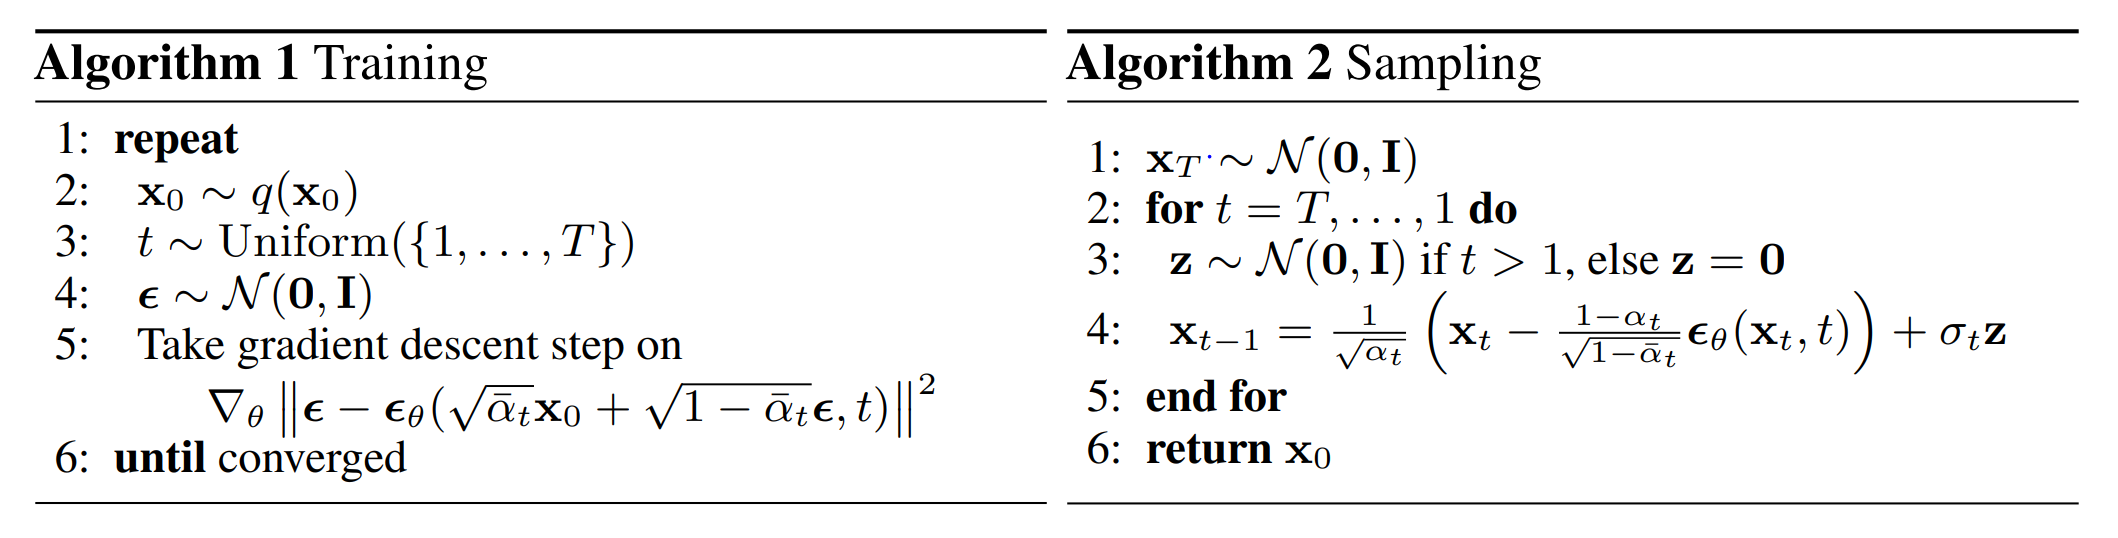

### 1.4.1 Noise scheduling
First of all, we need a variance scheduler for controlling the forward process. For the function in the cell below, define a linear variance scheduler $ \{\beta_t \in (0.0001, 0.04)\}^T_{t=1} $.

In [ ]:
def linear_beta_schedule(timesteps):
    """
    Create a linear beta schedule.

    Args:
        timesteps (int): The number of time steps.

    Returns:
        torch.Tensor: A tensor of beta values.
    """
    ##########################################################
    # TODO (1 points):
    # Complete the function with the described instructions.
    ##########################################################
    # Your code here...
    beta_start = 0.0001
    beta_end = 0.04
    return torch.linspace(beta_start, beta_end, timesteps)
    #################### END TODO ############################

### 1.4.2 Foward & Backward Processes

For training and sampling by our diffusion model, you should complete the methods of `Diffusion` class regarding descriptions for each method.

In [ ]:
class Diffusion:
    """
    Class for diffusion process.
    Attributes:
        time_steps (int): The number of time steps.
    """
    def __init__(self, time_steps):
        self.time_steps = time_steps

        ##########################################################
        # TODO (3 points):
        # Define beta, alpha, alpha_bar, ...
        # Use linear scheduler
        ##########################################################
        # Your code here...
        self.beta = linear_beta_schedule(time_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1. - self.alpha_bar)
        self.sqrt_recip_alpha = torch.sqrt(1.0 / self.alpha)
        #################### END TODO ############################

    def add_noise(self, x_0, t):
        """
        Add noise to the images.

        Args:
            x_0 (torch.Tensor): the batch of images.
            t (torch.Tensor): 1-D tensor indicating the time step of forward process.

        Returns:
            noisy_images (torch.Tensor): the batch of noisy images for time step t.
            noise (torch.Tensor): the noise added to images (\epsilon in Algorithm 1).
        """
        ##########################################################
        # TODO (4 points):
        # Complete the add_noise with the instructions above.
        ##########################################################
        # Your code here...
        sqrt_alpha_bar_t = gather(self.sqrt_alpha_bar, t)
        sqrt_one_minus_alpha_bar_t = gather(self.sqrt_one_minus_alpha_bar, t)
        noise = torch.randn_like(x_0)
        noised_images = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise
        return noised_images, noise
        #################### END TODO ############################

    def train_loss(self, model, x_0, t):
        """
        Computes the MSE loss for training the conditional denoiser model.

        Args:
            model: the denoising U-Net model.
            x_0 (torch.Tensor): the batch of images.
            t (torch.Tensor): 1-D tensor indicating the time step of forward process.
            label (torch.Tensor): 1-D tensor indicating labels.
        Returns:
            loss (torch.Tensor): the MSE loss for training the denoising model.
        """
        ##########################################################
        # TODO (2 points):
        # Complete the train_loss with the instructions above.
        ##########################################################
        # Your code here...
        x_t, noise = self.add_noise(x_0, t)
        pred_noise = model(x_t, t)
        loss = F.mse_loss(pred_noise, noise)
        return loss
        #################### END TODO ############################

    def denoise(self, x_t, pred_noise, t):
        """
        Sample the x_{t-1} from x_t in backward process.

        Args:
            x_t (torch.Tensor): the batch of noisy images for time step t.
            pred_noise (torch.Tensor): the predicted noise by denoising model.
            t (torch.Tensor): 1-D tensor indicating time step values.

        Returns:
            x_{t-1} (torch.Tensor): the sampled noisy images for time step (t-1).
        """
        ##########################################################
        # TODO (6 points):
        # Complete the denoise with the instructions above.
        ##########################################################
        # Your code here...
        sqrt_recip_alpha_t = gather(self.sqrt_recip_alpha, t)
        alpha_t = gather(self.alpha, t)
        alpha_bar_t = gather(self.alpha_bar, t)
        mean = sqrt_recip_alpha_t * (x_t - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * pred_noise)

        if t.min() > 0:
            noise = torch.randn_like(x_t) # langevin dynamics' noise ---> bring diversity
            beta_t = gather(self.beta, t)
            return mean + torch.sqrt(beta_t) * noise
        return mean
        #################### END TODO ############################

    def sample(self, n, model, device):
        """
        Complete the sampling algorithm and generate images.
        create a random noise and denoise it from time step T to time step 0 by using self.denoise method.

        Args:
            n (int): Number of generated images.
            model (torch.nn.Module): The UNet network for denoising.
            device (torch.device): Device to perform computations on.

        Returns:
            generated_images (List): the list of generated grayscale images.
        """
        ##########################################################
        # TODO (6 points):
        # Complete the sample with the instructions above.
        ##########################################################
        # Your code here...
        model.eval()
        x_t = torch.randn(n, 1, 28, 28).to(device=device)
        for step in reversed(range(self.time_steps)):
            t_batch = torch.full((n,), step, dtype=torch.long, device=device)
            with torch.no_grad():
               x_t = self.denoise(x_t, model(x_t, t_batch), t_batch)
        return x_t
        #################### END TODO ############################

In [ ]:
# Instantiate an object
time_steps = 200
diffusion = Diffusion(time_steps)

## 1.5. Training

At last, in this part we train the model and use it for generating MNIST images.

### 1.5.1 Train the model

Complete the training loop and train the `unet` for using in diffusion process.

In [ ]:
# Instantiate the model
unet = UnetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[2, 4]
)
unet = unet.to(device)

In [ ]:
##########################################################
# TODO (4 points):
# Set the number of epochs and optimizer
# Complete the training loop and train the model.
# Print the average loss of each epoch.
##########################################################
epochs = 5
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

for epoch in range(epochs):
  print(f'Epoch: {epoch}')
  # Your code here...

  unet.train()
  total_loss = 0
  num_batches = 0

  for x in tqdm(dataloader, total=len(dataloader)):
    x_0 = x[0].to(device)
    t = torch.randint(0, time_steps, (x_0.size(0),), device=device).long()

    optimizer.zero_grad()
    loss = diffusion.train_loss(unet, x_0, t)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    num_batches += 1

  avg_loss = total_loss / num_batches
  print(f'Average Loss: {avg_loss:.4f}')
#################### END TODO ############################

Epoch: 0


100%|██████████| 938/938 [04:14<00:00,  3.68it/s]


Average Loss: 0.0639
Epoch: 1


100%|██████████| 938/938 [04:26<00:00,  3.52it/s]


Average Loss: 0.0408
Epoch: 2


100%|██████████| 938/938 [04:26<00:00,  3.51it/s]


Average Loss: 0.0388
Epoch: 3


100%|██████████| 938/938 [04:26<00:00,  3.52it/s]


Average Loss: 0.0374
Epoch: 4


100%|██████████| 938/938 [04:26<00:00,  3.52it/s]

Average Loss: 0.0366


In [ ]:
# Save the trained model
path = "/content"
torch.save(unet.state_dict(), f'{path}/unconditional_unet.pth')

### 1.5.2 Visualize generated images

Sample 100 images from your model and visualize them.

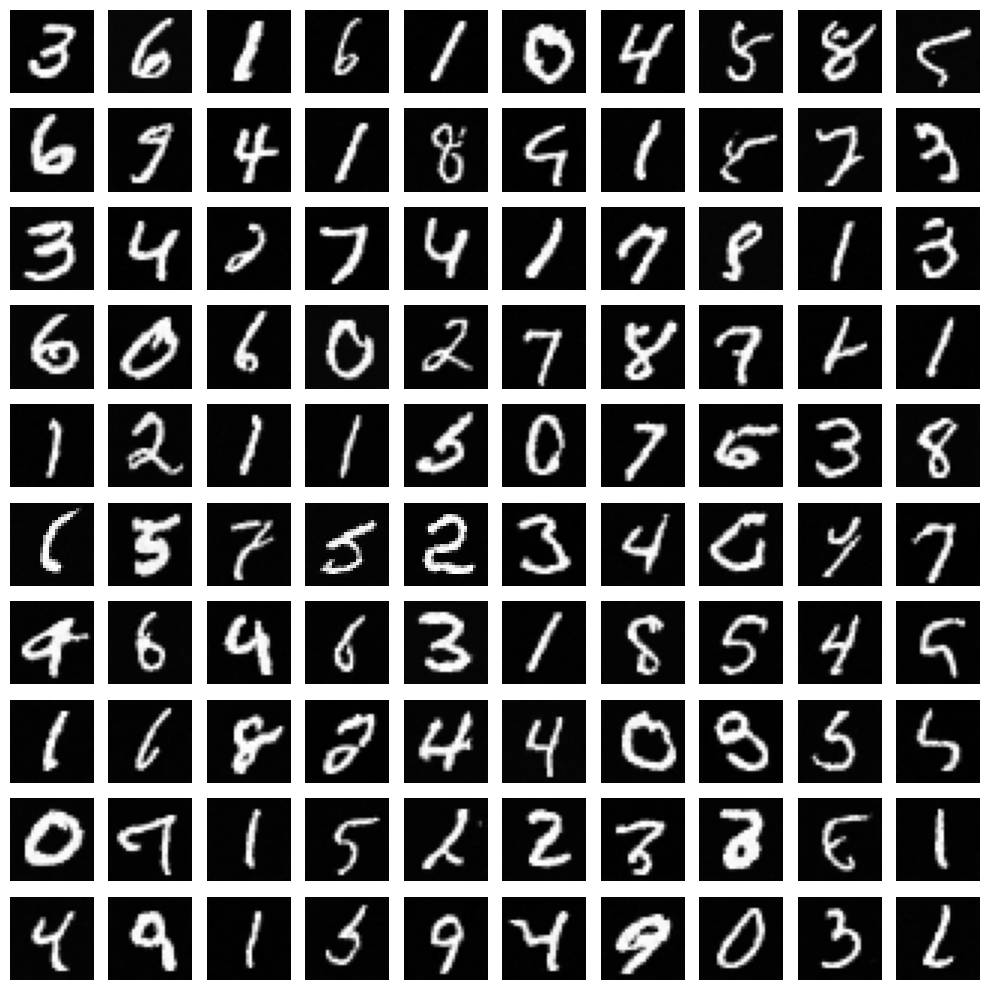

In [ ]:
##########################################################
# TODO (2 points):
# Generate 100 grayscale images and visualize them.
##########################################################
# Your code here...
unet.eval()
with torch.no_grad():
    generated_images = diffusion.sample(n=100, model=unet, device=device)

fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    img = generated_images[i].squeeze().cpu().numpy()
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()
#################### END TODO ############################

# 2. Conditional DDPM (extra 24 points)

For the second part of the assignment, we aim to develop the conditional diffusion model on the MNIST dataset. The main reference for this part is [classifier-free diffusion guidance paper.](https://arxiv.org/abs/2207.12598). Please note that by using the guidlines of the notebooks, you can complete this part and there is no need to read the paper carefully.

# Introduction

As you know, one way for developing conditional diffusion models is classifier guidance method in which an auxilary classifier is used. Classifier guidance mixes a diffusion model's score estimate with the input gradient of the log probability of a classifier. However, classifier guidance complicates the diffusion model training pipeline because it requires training an extra classifier, and this classifier must be trained on noisy data so it is generally not possible to plug in a pre-trained classifier.

In this part,  we aim to develop a conditional diffusion model without the need to use a classifier. For this purpose, we need to modify the architecture of U-Net model in the previous part to enable it for getting the label of images as inputs.

**Note**: For this part, You can use your codes from the previous part. Actually, by appling slight adjustments to previous codes, you can complete this part.

## 2.1 Conditional U-Net Architecture

As the new inputs for the conditional U-Net model, we need **two new inputs**:

* Input for class labels

* 0-1 Masks for determining unconditional / conditional model. (if 0, model doesn't use class labels for predicting noise, if 1, model use class labels for predicting noise.

The second input will be useful for training and sampling algorithms.

**Hint**: For modules of U-Net not mentioned here, you can use the implementations from the previous part.

### 2.1.1 time step and class embedding class
We define the `TimestepClassEmbedSequential` to support the time embedding as the extra input for the layers of model.

In [ ]:
class TimestepBlock(nn.Module):
    @abstractmethod
    def foward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """

class TimestepClassEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, t_emb, c_emb, mask):
        for layer in self:
            if(isinstance(layer, TimestepBlock)):
                x = layer(x, t_emb, c_emb, mask)
            else:
                x = layer(x)
        return x

### 2.1.2 Conditional Residual Block


First, we need to change the implementation of residual block. This modules gets **class labels embeddings** and **condition flag masks** as inputs. For implementation, you can use a *feed-forward layer for label embeddings, and apply the mask on the output of this layer*. Then, you can add the output to the time embedding and image embedding at the **residual connection**.

In [ ]:
# Residual block
class Conditional_Residual_block(TimestepBlock):
    """
    Conditional Residual block for Conditional U-Net architecture.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        time_channels (int): Size of the time embedding.
        class_channels (int): Size of the class embedding.
        dropout (float, optional): Dropout probability.
        num_groups (int): Number of groups to split the input into for normalization. Default is 32.
    """
    ##########################################################
    # TODO (6 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self, in_channels, out_channels, time_channels, class_channels, dropout, num_groups=32):
        super().__init__()

        # Your code here...
        self.norm1 = nn.GroupNorm(num_groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, out_channels)
        )

        self.class_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(class_channels, out_channels)
        )

        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels != out_channels:
            self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.skip_connection = nn.Identity()

    def forward(self, x, t_emb, c_emb, mask):
        """
        Forward pass of the ResnetBlock.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        # Your code here...
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        t_proj = self.time_emb(t_emb)          # (B, out_channels)
        c_proj = self.class_emb(c_emb)         # (B, out_channels)
        c_proj = c_proj * mask[:, None]        # Apply mask for classifier-free guidance

        emb = t_proj + c_proj                  # (B, out_channels)
        emb = emb[:, :, None, None]            # Reshape to (B, out_channels, 1, 1)
        h = h + emb

        h = self.norm2(h)
        h = F.silu(h)
        h = self.dropout(h)
        h = self.conv2(h)
        x = self.skip_connection(x)

        return h + x
    #################### END TODO ############################

### 2.1.3 Final Architecture

In this step, we implement the conditional U-Net model. You can use the same architecture used for the unconditional generation. However, you should use the contional residual connection to enable the model for the conditional generation.

Notes:
* Same as the time embedding, you need to transform the class labels to embedding vectors. For this purpose, you can use `nn.Embedding` module.

In [ ]:
class ConditionalUnetModel(nn.Module):
    """
    U-Net model for image generation.

    Args:
        in_channels (int): Number of input channels.
        model_channels (int): Number of channels in the model.
        out_channels (int): Number of output channels.
        num_res_blocks (int): Number of residual blocks at each level in the model.
        attention_resolutions (list): List of resolutions at which to apply attention.
        dropout (float): Dropout probability.
        channel_mult (list): List of channel multipliers for each stage (should be multiplied to model_channels).
        conv_resample (bool): Flag indicating whether to use convolution for up/down sampling blocks.
        num_heads (int): Number of attention heads.
        class_num (int): Number of classes.
        num_groups (int): Number of groups to split the input into for normalization.
    """
    ##########################################################
    # TODO (8 points):
    # Complete the init and forward methods with the described
    # instructions.
    ##########################################################
    def __init__(self,
                 in_channels=3,
                 model_channels=128,
                 out_channels=3,
                 num_res_blocks=2,
                 attention_resolutions=(8,16),
                 dropout=0,
                 channel_mult=(1,2,2,2),
                 conv_resample=True,
                 num_heads=4,
                 class_num=10,
                 num_groups=32):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.conv_resample = conv_resample
        self.num_heads = num_heads
        self.class_num = class_num
        self.num_groups = num_groups

        # time embedding
        # Your code here...
        time_emb_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        # class embedding
        # Your code here...
        self.class_embed = nn.Embedding(class_num, model_channels)

        # down blocks
        # Your code here...
        self.down_blocks = nn.ModuleList()
        self.down_blocks.append(TimestepClassEmbedSequential(
            nn.Conv2d(in_channels, model_channels, kernel_size=3, padding=1)
        ))
        block_channels = [model_channels]
        ch = model_channels
        ds = 1

        for level, mult in enumerate(channel_mult):

            for _ in range(num_res_blocks):
                layers = [Conditional_Residual_block(ch, mult * model_channels, time_emb_dim, model_channels, dropout, num_groups)]
                ch = mult * model_channels

                if ds in self.attention_resolutions:
                    layers.append(AttentionBlock(ch, num_groups=num_groups, num_heads=num_heads))
                self.down_blocks.append(TimestepClassEmbedSequential(*layers))
                block_channels.append(ch)

            if level != len(channel_mult) - 1:
                self.down_blocks.append(TimestepClassEmbedSequential(Downsample(ch, conv_resample)))
                block_channels.append(ch)
                ds *= 2

        # middle blocks
        # Your code here...
        self.middle_block = TimestepClassEmbedSequential(
            Conditional_Residual_block(ch, ch, time_emb_dim, model_channels, dropout, num_groups),
            AttentionBlock(ch, num_groups=num_groups, num_heads=num_heads),
            Conditional_Residual_block(ch, ch, time_emb_dim, model_channels, dropout, num_groups),
        )

        # up blocks
        # Your code here...
        self.up_blocks = nn.ModuleList()
        for level, mult in reversed(list(enumerate(channel_mult))):

            for i in range(num_res_blocks + 1):
                layers = [Conditional_Residual_block(ch + block_channels.pop(), model_channels * mult, time_emb_dim, model_channels, dropout, num_groups)]
                ch = mult * model_channels

                if ds in self.attention_resolutions:
                    layers.append(AttentionBlock(ch, num_groups=num_groups, num_heads=num_heads))

                if level and i == num_res_blocks:
                    layers.append(Upsample(ch, conv_resample))
                    ds //= 2
                self.up_blocks.append(TimestepClassEmbedSequential(*layers))

        # output layers
        # Your code here...
        self.out = nn.Sequential(
            nn.GroupNorm(num_groups, ch),
            nn.SiLU(),
            nn.Conv2d(model_channels, out_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, timesteps, c, mask):
        """
        Apply the model to an input batch.
        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :param c: a 1-D batch of classes.
        :param mask: a 1-D batch of conditioned/unconditioned.
        :return: an [N x C x ...] Tensor of outputs.
        """

        # Your code here...
        hs = []

        # time and class embedding
        t_emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))
        c_emb = self.class_embed(c) * mask[:, None]

        # down path
        h = x
        hs.append(h)
        for module in self.down_blocks:
            h = module(h, t_emb, c_emb, mask)
            hs.append(h)

        # middle path
        h = self.middle_block(h, t_emb, c_emb, mask)

        # up path
        for module in self.up_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, t_emb, c_emb, mask)

        return self.out(h)
    #################### END TODO ############################

## 2.2 Classifier-free guidance diffusion process

As it is stated in the reference paper, for training the model, we need to train it for both unconditional and conditional inputs. Therefore, we need to consider both inputs through training. The training algorithm is:

Training algorithm:

Require $p_{uncond}$: Probability of unconditional training

1. **repeat**
2. $ (x, c) \sim q(x, c)$
3. mask = 0 with the probability $p_{uncond}$
3. $t \sim Uniform(\{1, 2, ..., T\})$
4. $\epsilon \sim N(0, I)$
5. Take gradient descent on

&emsp;&emsp; $\nabla_{\theta} ||\epsilon - \epsilon_{\theta}(\sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}}\epsilon, t, c, mask)||$
6. **until** converged

For sampling, as the similar as the classifier guidance method, we need to use the predcited noise of conditional model to generate the image for a certain class. The sampling algorithm is:

Sampling algorithm

define $w$: guidance strength
1. $ x_T \sim N(0, I) $
2. for $ t = T, \ldots, 1 $ do
3. &emsp;&emsp;$ z \sim N(0, I) $ if $ t > 1 $, else $ z = 0 $
4. &emsp;&emsp;$\epsilon_{pred} = (1+w)\epsilon_{\theta}(x_t, t, c, I) - w\epsilon_{\theta}(x_t, t, c, 0)$
5. &emsp;&emsp;$ x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_{pred} \right) + \sigma_t z $
5. end for
6. return $ x_0 $

In [ ]:
class ConditionalDiffusion:
    """
    Class for conditional diffusion process.
    Attributes:
        time_steps (int): The number of time steps.
        w (int): Guidance strength parameter.
        p_uncond (float): Probability of unconditional training.
    """
    def __init__(self, time_steps, w=2, p_uncond=0.2):
        self.time_steps = time_steps
        self.w = w
        self.p_uncond = p_uncond

        ##########################################################
        # TODO (3 points):
        # Define beta, alpha, alpha_bar, ...
        # Use linear scheduler
        ##########################################################
        self.beta = linear_beta_schedule(time_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1. - self.alpha_bar)
        self.sqrt_recip_alpha = torch.sqrt(1.0 / self.alpha)
        #################### END TODO ############################

    def add_noise(self, x_0, t):
        """
        Add noise to the images.

        Args:
            x_0 (torch.Tensor): the batch of images.
            t (torch.Tensor): 1-D tensor indicating the time step of forward process.

        Returns:
            noisy_images (torch.Tensor): the batch of noisy images for time step t.
            noise (torch.Tensor): the noise added to images.
        """
        ##########################################################
        # TODO (4 points):
        # Complete the add_noise with the instructions above.
        ##########################################################
        # Your code here...
        sqrt_alpha_bar_t = gather(self.sqrt_alpha_bar, t)
        sqrt_one_minus_alpha_bar_t = gather(self.sqrt_one_minus_alpha_bar, t)
        noise = torch.randn_like(x_0)
        noised_images = sqrt_alpha_bar_t * x_0 + sqrt_one_minus_alpha_bar_t * noise
        return noised_images, noise
        #################### END TODO ############################

    def train_loss(self, model, x_0, t, label):
        """
        Computes the MSE loss for training the conditional denoiser model.

        Args:
            model: the denoising U-Net model.
            x_0 (torch.Tensor): the batch of images.
            t (torch.Tensor): 1-D tensor indicating the time step.
            label (torch.Tensor): 1-D tensor indicating labels.

        Returns:
            loss (torch.Tensor): the MSE loss for training.
        """
        ##########################################################
        # TODO (2 points):
        # Complete the train_loss with the instructions above.
        ##########################################################
        # Your code here...
        mask = (torch.rand(len(label), device=device) > self.p_uncond).float()
        x_t, noise = self.add_noise(x_0, t)
        pred_noise = model(x_t, t, label, mask)
        loss = F.mse_loss(pred_noise, noise)
        return loss
        #################### END TODO ############################

    def denoise(self, x_t, pred_noise, t):
        """
        Sample x_{t-1} from x_t during reverse diffusion.

        Args:
            x_t (torch.Tensor): the noisy image at time step t.
            pred_noise (torch.Tensor): predicted noise.
            t (torch.Tensor): current time step.

        Returns:
            x_{t-1} (torch.Tensor): denoised image.
        """
        ##########################################################
        # TODO (6 points):
        # Complete the denoise with the instructions above.
        ##########################################################
        sqrt_recip_alpha_t = gather(self.sqrt_recip_alpha, t)
        alpha_t = gather(self.alpha, t)
        alpha_bar_t = gather(self.alpha_bar, t)
        mean = sqrt_recip_alpha_t * (x_t - (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t) * pred_noise)
        if t.min() > 0:
            noise = torch.randn_like(x_t) # langevin dynamics' noise ---> bring diversity
            beta_t = gather(self.beta, t)
            return mean + torch.sqrt(beta_t) * noise
        return mean
        #################### END TODO ############################

    def sample(self, n, model, label, device):
        """
        Run the sampling algorithm to generate images.

        Args:
            n (int): Number of generated images.
            model (torch.nn.Module): The conditional U-Net.
            label (torch.Tensor): Class labels for conditional generation.
            device (torch.device): Device to perform computations.

        Returns:
            generated_images (List): List of generated grayscale images.
        """
        ##########################################################
        # TODO (6 points):
        # Complete the sample with the instructions above.
        ##########################################################
        # Your code here...
        label.to(device)
        model.eval()
        x_t = torch.randn(n, 1, 28, 28).to(device=device)

        for step in reversed(range(self.time_steps)):
            t_batch = torch.full((n,), step, dtype=torch.long, device=device)

            with torch.no_grad():
                condition = model(x_t, t_batch, label, torch.ones(n, device=device))
                uncondition = model(x_t, t_batch, label, torch.zeros(n, device=device))
                pred = (1 + self.w) * condition - self.w * uncondition
                x_t = self.denoise(x_t, pred, t_batch)
        return x_t
        #################### END TODO ############################

In [ ]:
# Get an instance
time_steps = 200
conditional_diffusion = ConditionalDiffusion(time_steps)

## 2.3 Training

### 2.3.1 Train the model

Complete the training loop and train the `conditional_unet` for using in diffusion process.

In [ ]:
conditional_unet = ConditionalUnetModel(
    in_channels=1,
    model_channels=96,
    out_channels=1,
    channel_mult=(1, 2, 2),
    attention_resolutions=[2, 4],
    class_num=10
)
conditional_unet = conditional_unet.to(device)

In [ ]:
##########################################################
# TODO (6 points):
# Set the number of epochs and optimizer
# Complete the training loop and train the model.
# Print the average loss of each epoch.
##########################################################
epochs = 2
optimizer = torch.optim.AdamW(conditional_unet.parameters(), lr=1e-4, weight_decay=1e-5)

for epoch in range(epochs):
  print(f'Epoch: {epoch + 1}')
  # Your code here...

  conditional_unet.train()
  total_loss = 0
  num_batches = 0

  for x in tqdm(dataloader, total=len(dataloader)):
    images = x[0].to(device)
    labels = x[1].to(device)

    t = torch.randint(0, time_steps, (images.size(0),), device=device).long()

    optimizer.zero_grad()
    loss = conditional_diffusion.train_loss(conditional_unet, images, t, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    num_batches += 1

  avg_loss = total_loss / num_batches
  print(f'Average Loss: {avg_loss:.7f}')
#################### END TODO ############################

Epoch: 1


100%|██████████| 938/938 [04:10<00:00,  3.74it/s]


Average Loss: 0.0670940
Epoch: 2


100%|██████████| 938/938 [04:12<00:00,  3.71it/s]

Average Loss: 0.0411591


In [ ]:
# Save the trained model
torch.save(conditional_unet.state_dict(), f'{path}/conditional_unet.pth')

### 2.3.2 Visualize generated images

For the visualization part, you should generate images of 0-9 classes 10 times and visualiza them like the output of below cell.

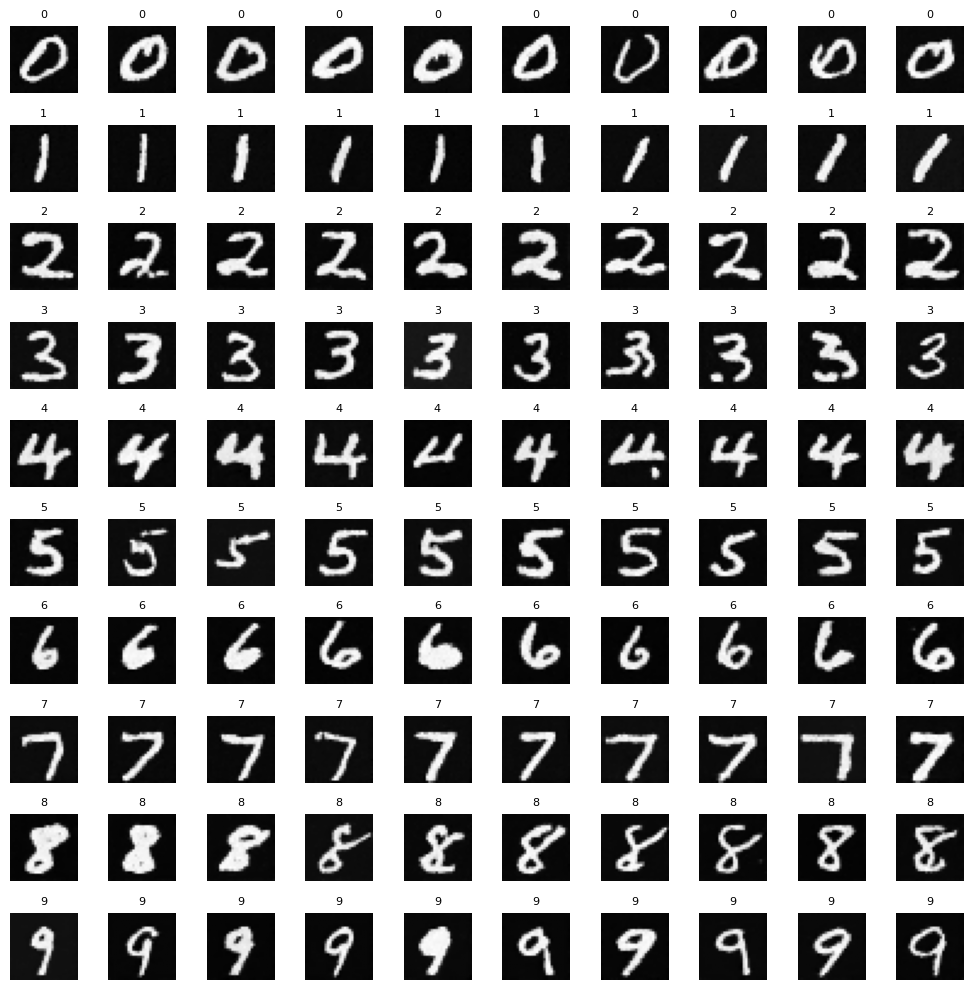

In [ ]:
##########################################################
# TODO (2 points):
# Generate 100 grayscale 0-9 images and visualize them.
##########################################################
# Your code here...
conditional_unet.eval()
generated_images = []
all_labels = []

with torch.no_grad():
    for digit in range(10):
        labels = torch.full((10,), digit, device=device)
        samples = conditional_diffusion.sample(10, conditional_unet, labels, device)
        generated_images.extend(samples)
        all_labels.extend(labels.cpu().tolist())

fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    img = generated_images[i].squeeze().cpu().numpy()
    label = all_labels[i]
    ax.imshow(img, cmap='gray')
    ax.set_title(str(label), fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()
#################### END TODO ############################

# 3. Evaluation (extra 10 points)

For this part, you should measure the quality of generated images by (unconditional or conditional model) in comparison to the real images. You are free to choose any appropriate metric for this purpose. Also, you are free to implement this part from scratch or use an additional library. In the cell below, write a brief description about your chosen metric and how it works.

`Your answer`:
### Evaluation Metric: Fréchet Inception Distance (FID)

To evaluate the quality of the generated images, we use the **Fréchet Inception Distance (FID)**. FID is a widely used metric for assessing the similarity between the distributions of real and generated images in a feature space. It provides a quantitative measure of how close the generated images are to real images.

#### How FID Works:
1. Both real and generated images are passed through a pretrained convolutional neural network (e.g., InceptionV3 or a lightweight alternative for MNIST).
2. Deep feature representations are extracted from a specific intermediate layer.
3. The distributions of these features (for real and generated images) are modeled as multivariate Gaussians.
4. The Fréchet Distance is then computed between these two Gaussians using the formula:

$
\text{FID} = \|\mu_r - \mu_g\|^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2})
$

- \( $\mu_r$, $\Sigma_r$ \): Mean and covariance of real image features  
- \( $\mu_g$, $\Sigma_g$ \): Mean and covariance of generated image features

#### Interpretation:
- **Lower FID values** indicate that the generated images are more similar to real images.
- An FID of **0** means the generated distribution is identical to the real one.


In [ ]:
##########################################################
# TODO (10 points):
# Evaluate the quality of generated images by choosing and using an appropriate metric.
##########################################################
# Your code here...
conditional_unet.eval()
labels_tensor = torch.arange(10).repeat_interleave(10).to(device)

with torch.no_grad():
    sampled_imgs = conditional_diffusion.sample(
        n=100,
        model=conditional_unet,
        device=device,
        label=labels_tensor
    )

# Collect real images with labels < 10
real_imgs_buffer = []
for batch_imgs, batch_labels in dataloader:
    valid_imgs = batch_imgs[batch_labels < 10]
    real_imgs_buffer.append(valid_imgs)
    if sum(imgs.size(0) for imgs in real_imgs_buffer) >= 100:
        break
real_imgs = torch.cat(real_imgs_buffer, dim=0)[:100]

# Define preprocessing transform
img_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    lambda img: img.repeat(3, 1, 1)
])

# Apply preprocessing
sampled_imgs_proc = torch.stack([img_transform(img.cpu()) for img in sampled_imgs])
real_imgs_proc = torch.stack([img_transform(img.cpu()) for img in real_imgs])

# Convert to byte tensor and move to device
sampled_imgs_proc = (sampled_imgs_proc * 255).clamp(0, 255).byte().to(device)
real_imgs_proc = (real_imgs_proc * 255).clamp(0, 255).byte().to(device)

# Compute Frechet Inception Distance
fid_metric = FrechetInceptionDistance(feature=64).to(device)
fid_metric.update(real_imgs_proc, real=True)
fid_metric.update(sampled_imgs_proc, real=False)

fid_result = fid_metric.compute().item()
print(f"FID score: {fid_result:.3f}")
#################### END TODO ############################

Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 441MB/s]


FID score: 0.086
